In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.feature_selection

Kernel regression methods like Gaussian Process Regression and Kernel Ridge Regression are two of the best known and best performing similarity based regression methods. They use a weighted sum over similarities between datapoitns to construct predictions of target values.

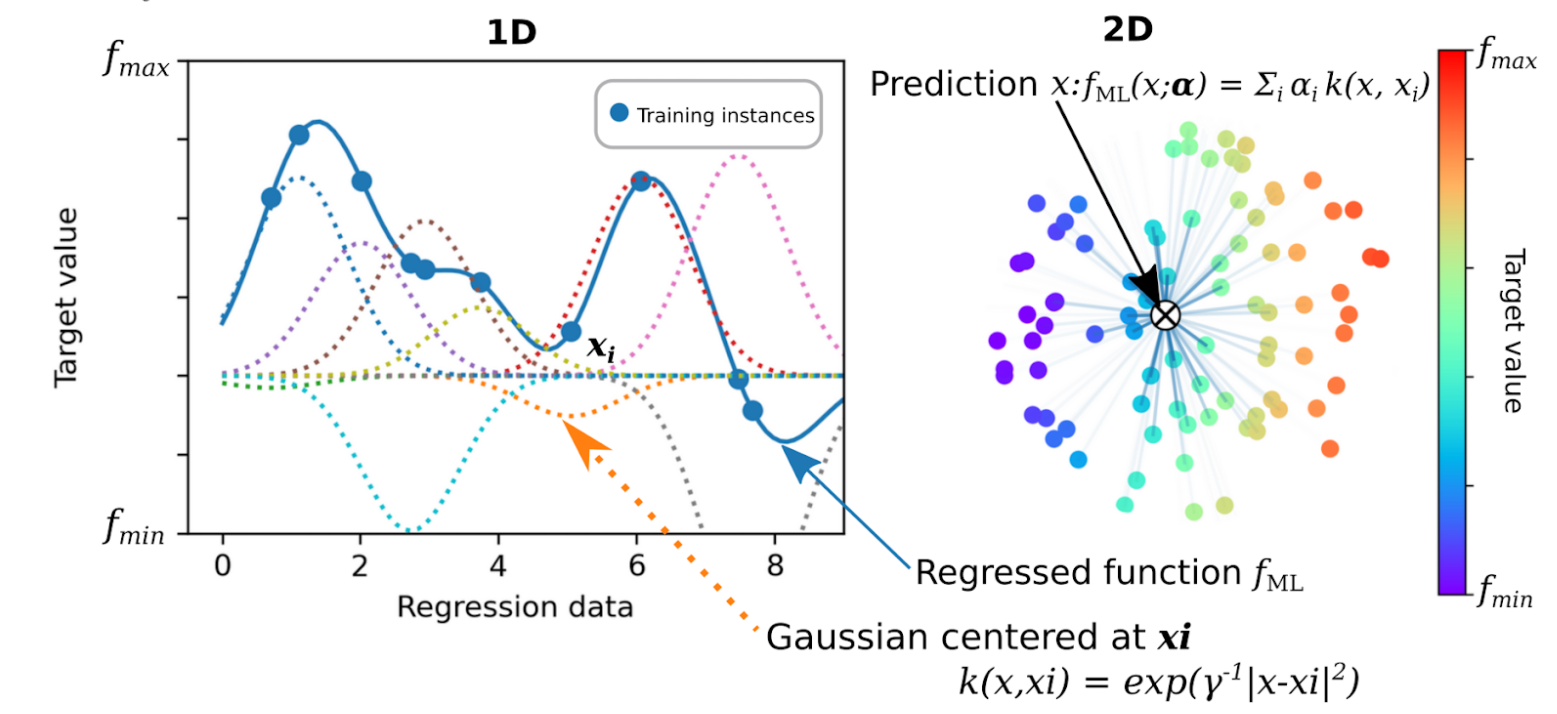

The $\alpha$ coefficients in KRR are obtained using the formula 

$\alpha = \frac{y}{K + \lambda I}$, where K is the kernel matrix ($K_{ij} = k(x_i, x_j)$)

Like all methods that use similarities, the performance of kernel methods is very sensitive to the quality of the similarity measure used to compare datapoints.

We will train now two Kernel Ridge Regression models using the two similarities developed in tutorial 1

In [46]:
# Create the data
nn = 5000 # number of points
dd = 6 # number of features
data = np.random.uniform(size=[nn,dd], low=-4, high=4)

target = 10 * np.cos(np.pi * 0.2 * (data[:,0] + data[:,1])) + 3 * np.cos(
    np.pi * 1 * (data[:,0] - data[:,1]))
inf = sk.feature_selection.mutual_info_regression(data, target)
data_mi = sk.preprocessing.StandardScaler().fit_transform(data)
data_mi *= np.sqrt(30 * inf)

# Separate train and test
indices_train, indices_test = sk.model_selection.train_test_split(
        np.arange(len(data)), train_size=0.7, test_size=0.3, random_state=0)

distance_matrix_original = sk.metrics.pairwise.pairwise_distances(data, n_jobs=-1)
distance_matrix_mi = sk.metrics.pairwise.pairwise_distances(data_mi, n_jobs=-1)

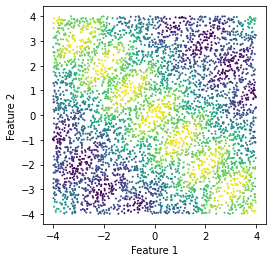

In [78]:
fig, ax = plt.subplots(figsize=[4,4])

ax.scatter(data[:, 0], data[:, 1], c=target, s=1)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
fig.savefig('./art_data.eps')

In [4]:
# KRR training with original data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(1,5, 5)
# params = np.linspace(0.01,0.1, 5)

predictions_test = []
scores_test = []

regg = 1e-9

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_original[indices_train, :][:, indices_train] ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_original[indices_test, :][:, indices_train] ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae=np.mean(np.abs(Y_predicted - target[indices_test]))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_original = predictions_test[best_indx]

SIGMA:  1.0
MAE:  6.164
SIGMA:  2.0
MAE:  3.028
SIGMA:  3.0
MAE:  3.052
SIGMA:  4.0
MAE:  4.099
SIGMA:  5.0
MAE:  5.576
1


In [5]:
# KRR training with modified data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(0.1,3, 5)
# params = np.linspace(0.01,0.1, 5)

predictions_test = []
scores_test = []

regg = 1e-9

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mi[indices_train, :][:, indices_train] ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mi[indices_test, :][:, indices_train] ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae=np.mean(np.abs(Y_predicted - target[indices_test]))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_mi = predictions_test[best_indx]

SIGMA:  0.1
MAE:  6.63
SIGMA:  0.825
MAE:  0.85
SIGMA:  1.55
MAE:  0.414
SIGMA:  2.275
MAE:  1.262
SIGMA:  3.0
MAE:  5.262
2


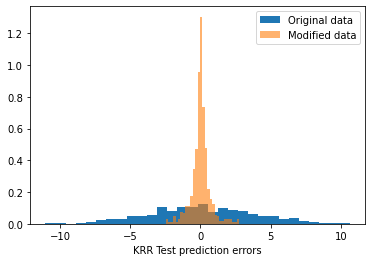

In [6]:
fig, ax = plt.subplots()

ax.hist(predictions_test_original - target[indices_test], bins=30, density=True, label='Original data')
ax.hist(predictions_test_mi - target[indices_test], bins=30, density=True, alpha=0.6, label='Modified data')
ax.legend()
ax.set_xlabel('KRR Test prediction errors')
plt.show()

The KRR trained with feature importances scaled to match the MI between the features and the target clearly shows a better performance.

However, while the MI regression provides a simple method to identify likely relevant features, it does not provide a design method to provide a feature space that optimize the prediction accuracy of a kernel regression.

Such type of tehcniques, known as metric learning methods, are few in number. One of the few examples is Metric Learning for Kernel Regression, or MLKR.

http://proceedings.mlr.press/v2/weinberger07a/weinberger07a.pdf


MLKR is a method that learns a transformation matrix $\textbf{A}$ that optimizes the Euclidean distance for a kernel regression:

$d(x_i, x_j) = ||\textbf{A}(x_i - x_j)||^2$,

also known as a Mahalanobis distance. The matrix A is able to scale each feature and to create new features using linear combinations of the original features.

MLKR uses a different way regression method than KRR. Instead of regressing the $\alpha$ coefficients, it uses a non-parametric estimator called Nadaraya–Watson estimator:

$f(x) = \frac{\sum_i k(x, x_i) y_i}{\sum_i k(x, x_i)}$

In [48]:
import importlib

import mlkrr
importlib.reload(mlkrr)

<module 'mlkrr' from '/home/fabregat/work/qml/metric_learning/metric_learning_tutorials/mlkrr.py'>

In [49]:
mlkrr

<module 'mlkrr' from '/home/fabregat/work/qml/metric_learning/metric_learning_tutorials/mlkrr.py'>

In [50]:
mlkr = mlkrr.MLKR(verbose=True)
mlkr.fit(data[indices_train], target[indices_train])

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
Train RMSE: 3.562
Train MAE: 2.823
[MLKR]          0         4.441578e+04       0.69
Train RMSE: 2.521
Train MAE: 2.103
[MLKR]          1         2.223945e+04       0.69
Train RMSE: 2.326
Train MAE: 1.986
[MLKR]          2         1.893228e+04       0.76
Train RMSE: 2.196
Train MAE: 1.92
[MLKR]          3         1.687339e+04       0.73
Train RMSE: 2.261
Train MAE: 1.974
[MLKR]          4         1.788619e+04       0.75
Train RMSE: 2.166
Train MAE: 1.912
[MLKR]          5         1.642723e+04       0.67
Train RMSE: 2.154
Train MAE: 1.908
[MLKR]          6         1.623502e+04       0.70
Train RMSE: 2.142
Train MAE: 1.904
[MLKR]          7         1.606174e+04       0.69
Train RMSE: 2.131
Train MAE: 1.898
[MLKR]          8         1.589010e+04       0.71
Train RMSE: 2.126
Train MAE: 1.893
[MLKR]          9         1.581638e+04       0.70
Train RMSE: 2.123
Train MAE: 1.892
[MLKR]   

[MLKR]         59         1.534513e+04       0.91
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         60         1.534512e+04       0.77
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         61         1.534509e+04       0.82
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         62         1.534508e+04       0.83
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         63         1.534506e+04       0.78
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         64         1.534505e+04       0.93
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         65         1.534504e+04       0.76
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         66         1.534503e+04       0.83
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         67         1.534502e+04       0.84
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         68         1.534502e+04       0.86
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         69         1.534502e+04       0.80
Train RMSE: 2.094
Train MAE: 1.864
[MLKR]         70         1.534502e+04       0.79
Train RMSE: 2.0

After training, we can analyze the learned matrix A

In [51]:
np.round(mlkr.A, 1)

array([[ 2.1,  2.4, -0. ,  0.1, -0.1, -0. ],
       [ 2.5,  2. ,  0. , -0.2,  0.1,  0.1],
       [-0.1, -0. , -0. ,  0. , -0. , -0. ],
       [-0.1,  0.1,  0.1, -0.1,  0.1,  0.1],
       [ 0.2, -0.3,  0. , -0.2,  0.2,  0.1],
       [-0.1, -0.1, -0.1,  0.2, -0.1, -0.2]])

The matrix $A^TA$ shows the importance of each feature.

In [52]:
np.round(mlkr.A.T @ mlkr.A, 1)

array([[10.5,  9.8,  0.1, -0.3,  0.2,  0.1],
       [ 9.8,  9.8,  0.1, -0.1,  0.1,  0. ],
       [ 0.1,  0.1,  0. , -0. ,  0. ,  0. ],
       [-0.3, -0.1, -0. ,  0.1, -0.1, -0.1],
       [ 0.2,  0.1,  0. , -0.1,  0.1,  0.1],
       [ 0.1,  0. ,  0. , -0.1,  0.1,  0.1]])

 We can create a new set of features using the learned Mahalanobis transformation

In [53]:
data_mlkr = data @ mlkr.A.T

In [54]:
distance_matrix_mlkr = sk.metrics.pairwise.pairwise_distances(data_mlkr, n_jobs=-1)

In [14]:
# MLKR predictions
from scipy.special import logsumexp

dist = distance_matrix_mlkr[indices_test, :][:, indices_train].copy()
softmax = np.exp(- dist - logsumexp(- dist, axis=1)[:, np.newaxis])
predictions_test_mlkr = softmax.dot(target[indices_train])


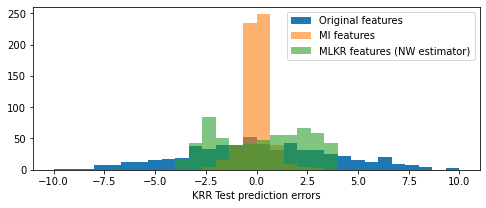

In [15]:
fig, ax = plt.subplots(figsize=[8,3])

ax.hist(predictions_test_original - target[indices_test], 
        bins=30, density=False, label='Original features', range=[-10,10])
ax.hist(predictions_test_mi - target[indices_test], 
        bins=30, density=False, alpha=0.6, label='MI features', range=[-10,10])
ax.hist(predictions_test_mlkr - target[indices_test], 
        bins=30, density=False, alpha=0.6, label='MLKR features (NW estimator)', range=[-10,10])

ax.legend()
ax.set_xlabel('KRR Test prediction errors')
plt.show()

The NW estimator is not very accurate. Nevertheless, we can use the learned metric in a KRR.

In [78]:
# KRR training with modified data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(0.1,10, 5)
# params = np.linspace(0.01,0.1, 5)

predictions_test = []
scores_test = []

regg = 1e-9

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mlkr[indices_train, :][:, indices_train] ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mlkr[indices_test, :][:, indices_train] ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae=np.mean(np.abs(Y_predicted - target[indices_test]))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_mlkr_krr = predictions_test[best_indx]

SIGMA:  0.1
MAE:  6.62
SIGMA:  2.575
MAE:  0.099
SIGMA:  5.05
MAE:  0.026
SIGMA:  7.525
MAE:  0.015
SIGMA:  10.0
MAE:  0.036
3


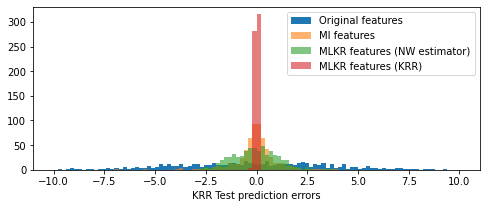

In [79]:
fig, ax = plt.subplots(figsize=[8,3])

ax.hist(predictions_test_original - target[indices_test], 
        bins=100, density=False, label='Original features', range=[-10,10])
ax.hist(predictions_test_mi - target[indices_test], 
        bins=100, density=False, alpha=0.6, label='MI features', range=[-10,10])
ax.hist(predictions_test_mlkr - target[indices_test], 
        bins=100, density=False, alpha=0.6, label='MLKR features (NW estimator)', range=[-10,10])
ax.hist(predictions_test_mlkr_krr - target[indices_test], 
        bins=100, density=False, alpha=0.6, label='MLKR features (KRR)', range=[-10,10])

ax.legend()
ax.set_xlabel('KRR Test prediction errors')
plt.show()

From this plot we can see that not only removing irrelevant features is important. The adequate scaling and creation of new features also is critical to optimize regression performance.

However, even though MLKR performes well in many situations, sometimes it is incapable to adequately construct the optimal metric for KRR. This is because it optimises the matrix A for the NW estimator, rather than for KRR.

For this reason, we developped a new metric learning algorithm called Metric Learning for Kernel Ridge Regression, or MLKRR

MLKRR learns a matrix A like MLKR, but using the estimator of KRR. As KRR uses a parametric regression to optimize the coefficients $\alpha$, the training data has to be divided into two sets: one to optimize $\alpha$ and one to optimize the matrix A. Essentially, MLKRR optimizes the matrix A in order to minimize the error predictions done in the second test set.

In order to prevent overfitting, the data is shuffled every N optimization steps and reseparated into two sets.

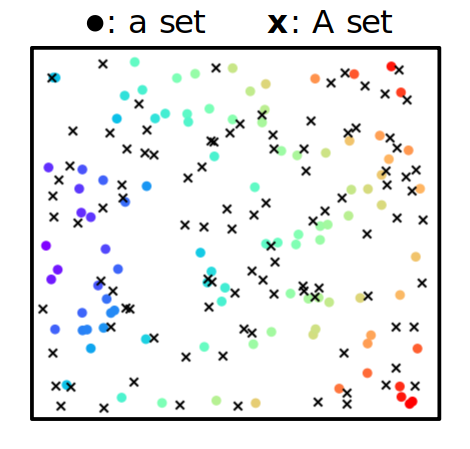

In [55]:
model = mlkrr.MLKRR(
    verbose=True, shuffle_iterations=5, 
    max_iter_per_shuffle=20, krr_regularization = 1e-9,
    size1=0.3, size2=0.7)

In [56]:
model.fit(data[indices_train], target[indices_train])

Starting shuffle iteration:  0
[MLKRR]
[MLKRR]  Iteration      Objective Value    Time(s)
[MLKRR] ------------------------------------------
Train RMSE: 7.069
Train MAE: 6.267
========= shuffle: 0,  iteration: 0 ==============
[MLKRR]          0         1.224387e+05       1.93
Train RMSE: 4.531
Train MAE: 3.762
========= shuffle: 0,  iteration: 1 ==============
[MLKRR]          1         5.029790e+04       1.13
Train RMSE: 7.28
Train MAE: 6.457
========= shuffle: 0,  iteration: 2 ==============
[MLKRR]          2         1.298506e+05       2.27
Train RMSE: 5.588
Train MAE: 4.142
========= shuffle: 0,  iteration: 3 ==============
[MLKRR]          3         7.650122e+04       1.25
Train RMSE: 3.12
Train MAE: 2.535
========= shuffle: 0,  iteration: 4 ==============
[MLKRR]          4         2.385153e+04       2.15
Train RMSE: 5.63
Train MAE: 4.285
========= shuffle: 0,  iteration: 5 ==============
[MLKRR]          5         7.766414e+04       1.90
Train RMSE: 3.113
Train MAE: 2.529
=====

Train RMSE: 2.862
Train MAE: 2.344
========= shuffle: 2,  iteration: 57 ==============
[MLKRR]         57         2.006194e+04       1.08
Train RMSE: 2.836
Train MAE: 2.308
========= shuffle: 2,  iteration: 58 ==============
[MLKRR]         58         1.970221e+04       0.35
Train RMSE: 2.829
Train MAE: 2.304
========= shuffle: 2,  iteration: 59 ==============
[MLKRR]         59         1.960796e+04       1.00
Train RMSE: 2.81
Train MAE: 2.297
========= shuffle: 2,  iteration: 60 ==============
[MLKRR]         60         1.934594e+04       0.31
Train RMSE: 2.813
Train MAE: 2.281
========= shuffle: 2,  iteration: 61 ==============
[MLKRR]         61         1.938284e+04       0.31
Train RMSE: 2.789
Train MAE: 2.278
========= shuffle: 2,  iteration: 62 ==============
[MLKRR]         62         1.906352e+04       0.40
Train RMSE: 2.772
Train MAE: 2.264
========= shuffle: 2,  iteration: 63 ==============
[MLKRR]         63         1.882752e+04       1.15
Train RMSE: 2.76
Train MAE: 2.254
=

Train RMSE: 0.49
Train MAE: 0.206
========= shuffle: 4,  iteration: 115 ==============
[MLKRR]        115         5.873780e+02       0.35
Train RMSE: 0.474
Train MAE: 0.2
========= shuffle: 4,  iteration: 116 ==============
[MLKRR]        116         5.500875e+02       0.43
Train RMSE: 0.464
Train MAE: 0.237
========= shuffle: 4,  iteration: 117 ==============
[MLKRR]        117         5.266109e+02       0.38
Train RMSE: 0.428
Train MAE: 0.192
========= shuffle: 4,  iteration: 118 ==============
[MLKRR]        118         4.488424e+02       0.61
Train RMSE: 0.42
Train MAE: 0.169
========= shuffle: 4,  iteration: 119 ==============
[MLKRR]        119         4.313380e+02       0.69
Train RMSE: 0.41
Train MAE: 0.152
========= shuffle: 4,  iteration: 120 ==============
[MLKRR]        120         4.126388e+02       1.57
Train RMSE: 0.389
Train MAE: 0.146
========= shuffle: 4,  iteration: 121 ==============
[MLKRR]        121         3.710600e+02       0.56
Train RMSE: 0.484
Train MAE: 0.2

/home/fabregat/work/qml/metric_learning/metric_learning_tutorials/mlkrr.py:138: ConvergenceWarning: [MLKRR] MLKR did not converge: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  warnings.warn(


In [57]:
np.round(model.A.T @ model.A, 1)

array([[ 1.6, -0. ,  0.1,  0.2, -0. , -0.1],
       [-0. ,  1.8,  0.1,  0.2, -0. , -0.1],
       [ 0.1,  0.1,  0. ,  0. , -0. , -0. ],
       [ 0.2,  0.2,  0. ,  0. , -0. , -0. ],
       [-0. , -0. , -0. , -0. ,  0. ,  0. ],
       [-0.1, -0.1, -0. , -0. ,  0. ,  0. ]])

In [58]:
np.round(model.A, 1)

array([[ 1.2,  0. ,  0.1,  0.1, -0. , -0. ],
       [-0.1,  1.3,  0.1,  0.1, -0. , -0. ],
       [-0. ,  0.1,  0. ,  0. , -0. , -0. ],
       [ 0.1, -0. ,  0. ,  0.1, -0. , -0. ],
       [-0.1, -0.1, -0. , -0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0. , -0. ]])

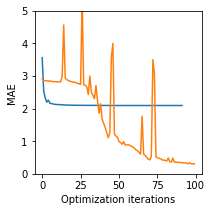

In [72]:
fig, ax = plt.subplots(figsize=[3,3])

ax.plot(mlkr.train_rmses)
ax.plot(model.train_rmses[-100:])
ax.set_xlabel('Optimization iterations')
ax.set_ylabel('MAE')
ax.set_ylim(0,5)
plt.show()
fig.savefig('./lcs_test.eps')

In [104]:
data_mlkrr = data @ model.A.T

In [105]:
distance_matrix_mlkrr = sk.metrics.pairwise.pairwise_distances(data_mlkrr, n_jobs=-1)

In [106]:
# KRR training with modified data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(1,2, 5)
# params = np.linspace(0.01,0.1, 5)

predictions_test = []
scores_test = []

regg = 1e-9

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mlkrr[indices_train, :][:, indices_train] ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * distance_matrix_mlkrr[indices_test, :][:, indices_train] ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae=np.mean(np.abs(Y_predicted - target[indices_test]))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_mlkr_krr = predictions_test[best_indx]

SIGMA:  1.0
MAE:  0.024
SIGMA:  1.25
MAE:  0.018
SIGMA:  1.5
MAE:  0.011
SIGMA:  1.75
MAE:  0.011
SIGMA:  2.0
MAE:  0.013
3


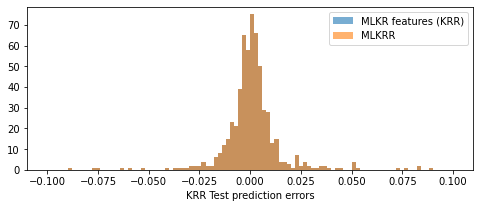

In [110]:
fig, ax = plt.subplots(figsize=[8,3])

ax.hist(predictions_test_mlkr_krr - target[indices_test], 
        bins=100, density=False, alpha=0.6, label='MLKR features (KRR)', range=[-0.1,0.1])
ax.hist(predictions_test_mlkr_krr - target[indices_test], 
        bins=100, density=False, alpha=0.6, label='MLKRR', range=[-0.1,0.1])

ax.legend()
ax.set_xlabel('KRR Test prediction errors')
plt.show()

For this simple example, both methods obtain very similar metrics and therefore the final accuracy is the same.